# Classifying Radiohead lyrics with super vector distribution

## Motivation

I wrote my thesis this semester related to LLM-agents and it included a research on the topic of NLP. I found especially interesting the discoveries of Mikolov et al. ([Mikolov et al. 2013](https://arxiv.org/abs/1301.3781)) about word embeddings and interesting relationships between them. Their work showcased that we can represent semantic meanings of words precisely in finite dimensions and many question have come to my mind:

- What if we use the words' semantic representations for **unsupervised clustering**?
- What are the **words represented by a cluster**? Do they represent easiliy interpretable connections?
- Can we use these clusters for **document classifying**?

I decided that I will dvelve more deeply on the topic and try to answer these questions on the corpus of the radiohead lyrics.

During the research for this project, I found a method by Butnaru et al. ([Butnaru et al. 2017](https://sciencedirect.com/science/article/pii/S1877050917316071)) where they implemented **k-means clustering** to create ***super word vectors*** and then classified documents based on the distribution of super word vectors in each document. Their algorithm is similar to what I initially planned to do so I decided to follow the same logic, but I will try a **hierarhichal clustering** algorithm, and I will also use **dimension reduction** based on the corpus to see wether it helps the quality of the clustering. For the classification part my documents will be the radiohead song lyrics and the classes will be assigned to the albums.

The main goal of the research is to experience with some of the learned techniques of a Data Science course I took at the University and to satisfy my curiosity. I am aware that using word embeddings isn't the most preferable approach for document classification and it would be more logical to use text embedding models on longer text chunks. This solution on the other hand doesn't require the high computing power of such models and can be trained on relatively shorter document sets.


In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA

In [4]:
with open(Path('data/embeddings.csv')) as f:
    embeddings = pd.read_csv(f, index_col=0)

with open(Path('data/radiohead_extended.csv')) as f:
    radiohead = pd.read_csv(f)

In [5]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
lock,0.017944,0.193359,-0.062988,0.024292,0.001579,0.075195,-0.057129,0.139648,0.269531,0.027710,...,0.039062,0.277344,0.102539,0.100586,-0.030518,-0.144531,-0.123047,-0.218750,-0.049561,0.026978
path,0.083496,0.138672,0.005829,0.213867,0.024902,-0.131836,0.121094,-0.412109,-0.236328,0.349609,...,-0.062988,0.154297,-0.226562,0.055420,0.047363,-0.046875,0.109863,0.036865,0.032471,0.019897
microwave,-0.300781,-0.066895,0.075684,0.324219,-0.030762,0.013245,0.172852,-0.328125,0.022461,0.239258,...,-0.103027,-0.019165,-0.410156,0.214844,-0.012451,-0.515625,-0.011963,0.007416,-0.075684,0.219727
dealers,0.135742,0.170898,-0.042969,0.298828,-0.008240,0.053955,-0.033447,0.085938,-0.041016,0.314453,...,0.049561,0.167969,-0.177734,-0.062500,0.335938,0.104492,-0.144531,0.107422,0.152344,-0.660156
bouncing,-0.180664,0.110840,-0.104004,0.125977,-0.053955,-0.234375,-0.187500,0.202148,0.154297,0.289062,...,-0.271484,0.175781,0.032227,-0.136719,0.201172,0.081543,0.240234,-0.130859,0.067383,-0.025024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
disappears,0.281250,0.204102,-0.237305,0.006470,-0.433594,0.015869,0.146484,-0.187500,0.343750,0.060303,...,-0.116699,0.189453,-0.159180,0.168945,-0.034424,0.257812,0.009705,-0.257812,0.091797,0.091797
pigskin,0.073730,-0.084473,0.032959,0.204102,-0.084961,-0.179688,0.185547,-0.101562,0.031128,0.155273,...,-0.005768,-0.056152,-0.145508,0.041504,0.441406,0.246094,0.208984,0.107910,-0.173828,0.167969
plastic,-0.204102,0.324219,-0.035645,0.004303,-0.178711,0.108398,0.080078,-0.066406,0.071289,0.312500,...,-0.259766,-0.236328,-0.114258,-0.032471,-0.126953,-0.001892,0.253906,0.173828,-0.011353,-0.077148
phone,-0.014465,-0.127930,-0.115723,-0.221680,-0.073730,-0.059814,-0.100098,-0.068848,0.149414,0.101074,...,-0.079102,0.157227,-0.061523,-0.174805,0.080078,-0.136719,-0.183594,-0.052002,-0.005859,-0.156250


In [6]:
embeddings_vector = np.array(embeddings.iloc[:, 1:])
embeddings_vector.dtype

dtype('float64')

## Clustering using original embeddings

In [88]:
# I will try different linkage methods to find a cluster number that fits the data representation
model_average = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, 
                                compute_distances = True,  # We want to determine the clusters based on the distances
                                metric="cosine",  # They usually use cosine for text embeddings and it is not as computational heavy
                                linkage="average")  # I use the average values for each cluster to determine the distances
model_average.fit(embeddings_vector)

model_min = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, 
                                compute_distances = True,
                                metric="cosine",
                                linkage="single")
model_min.fit(embeddings_vector)

model_max = AgglomerativeClustering(distance_threshold=0,
                                n_clusters=None, 
                                compute_distances = True,
                                metric="cosine",
                                linkage="complete")
model_max.fit(embeddings_vector)

AgglomerativeClustering(compute_distances=True, distance_threshold=0,
                        linkage='complete', metric='cosine', n_clusters=None)

In [89]:
model_average.labels_

array([1530, 1433, 1525, ...,    5,    2,    0])

In [90]:
def plot_dendrogram(model, n_clusters, **kwargs):
    # Create linkage matrix
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Calculate the color threshold to get the desired number of clusters
    distances = linkage_matrix[:, 2]  # Distances of merges
    if n_clusters > 1:
        # Find the threshold just below the merge that results in n_clusters
        threshold = sorted(distances, reverse=True)[n_clusters - 2]
    else:
        threshold = max(distances) + 1  # Single cluster case

    # Plot dendrogram with colors
    dendrogram(linkage_matrix, color_threshold=threshold, **kwargs)

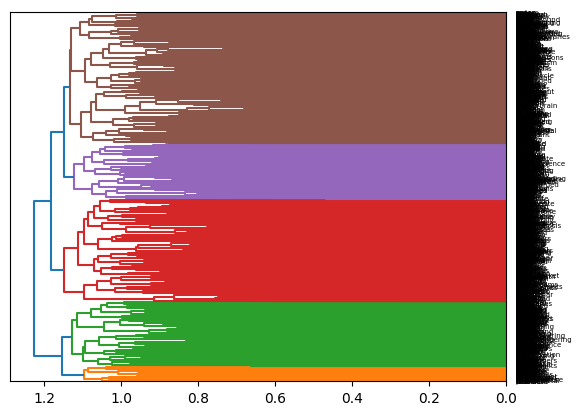

In [91]:
# Bit messy for 1750 words
plot_dendrogram(model_max, n_clusters=5, truncate_mode="level", labels = embeddings.index, orientation = 'left')

In [15]:
# I would like to find a cluster number that fits the dataset most, try to use the 'elbow method'
# Create three separate subplots for different linkage methods, I will only use the top 50 distances as I don't want to use more than 50 clusters anyway
distances = {
    'average': sorted(model_average.distances_)[-50:],
    'single': sorted(model_min.distances_)[-50:],
    'complete': sorted(model_max.distances_)[-50:],
}

fig = go.Figure()
fig = make_subplots(rows=3, cols=1, subplot_titles=('Average Linkage', 'Single Linkage', 'Complete Linkage'))

fig.add_trace(
    go.Scatter(y=distances['average'], mode='lines', name='Average Linkage'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(y=distances['single'], mode='lines', name='Single Linkage'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(y=distances['complete'], mode='lines', name='Complete Linkage'),
    row=3, col=1
)

# Update layout
fig.update_layout(
    height=900,  # Make figure taller to accommodate subplots
    title_text='Hierarchical Clustering Distances by Linkage Method',
    showlegend=False
)

# Update x and y axis labels for each subplot
fig.update_xaxes(title_text="Merge Step", row=3, col=1)
fig.update_yaxes(title_text="Distance", row=2, col=1)

fig.show()

Complete linkage at 6 looks the most similar to the elbow form, but I think more clusters could be more interesting so I went with complete linkage at 14

In [82]:
n_clusters = 14
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', metric='cosine')
model.fit(embeddings_vector)

AgglomerativeClustering(linkage='complete', metric='cosine', n_clusters=14)

In [84]:
embeddings['labels_all_dimension'] = model.labels_

grouped = embeddings[['labels_all_dimension', '0']].groupby('labels_all_dimension').count()

fig = px.bar(grouped, title="Distribution of words by cluster", labels={'value': 'Count', 'labels_all_dimension': 'Cluster'})
fig.update_layout(showlegend=False)
fig.show()

In [86]:
def cosine_similarity(a, b):
    # Compute dot product
    dot_product = np.dot(a, b)
    # Compute norms
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    # Return cosine similarity
    return dot_product / (norm_a * norm_b)

# Calculate distances from each point to the cluster center
cluster_centers = embeddings.groupby('labels_all_dimension').mean()

# Calculate distance to cluster center
embeddings['distance_to_center'] = embeddings.apply(lambda x: cosine_similarity(x.iloc[:-1], cluster_centers.iloc[int(x.iloc[0])]), axis=1)

# Get 10 closest points to their cluster centers
for i in range(n_clusters):
    closest_points = embeddings[embeddings['labels_all_dimension'] == i].nsmallest(10, 'distance_to_center')[['distance_to_center', 'labels_all_dimension']]
    print(f"\nWords closest to cluster center {i}:")
    print(', '.join(closest_points.index))



Words closest to cluster center 0:
figures, number, talks, networking, spoke, mission, channels, kicks, speakers, bribed

Words closest to cluster center 1:
k, instrumental, member, covers, president, dedicated, vice, associate, employee, list

Words closest to cluster center 2:
c, na, january, et, ha, german, x, april, solo, ca

Words closest to cluster center 3:
driven, pace, jumped, meet, schedules, disinfected, fell, pounds, grow, polystyrene

Words closest to cluster center 4:
fracturing, closed, range, reach, shutdown, lead, pane, reaching, goals, mark

Words closest to cluster center 5:
produced, released, release, th, st, receive, receiving, credit, raised, records

Words closest to cluster center 6:
cathode, plant, years, erased, aircrash, century, battery, half, tracks, minute

Words closest to cluster center 7:
trails, company, domestic, made, second, since, circuit, market, last, five

Words closest to cluster center 8:
holds, found, laid, given, gave, taking, took, brough

In [95]:
# I named the cluster with an LLM based on the words in the middle
clusters = {
    0: "Communication & Speaking",     # focused on verbal interaction and networking
    1: "Professional Roles & Titles",  # related to organizational positions and roles 
    2: "Time & References",            # contains dates, abbreviations, and reference terms
    3: "Movement & Growth",            # words about motion, development, and physical change
    4: "Goals & Boundaries",           # related to objectives, limits, and reaching targets
    5: "Production & Publishing",      # focused on releasing and crediting content
    6: "Time & Technology",            # mix of temporal and technical/mechanical terms
    7: "Business & Market",            # related to commercial and business activities
    8: "Action & Possession",          # verbs related to taking, giving, and holding
    9: "Business Metrics",             # focused on numbers, sales, and business outcomes
    10: "Family & Mortality",          # personal relationships and life/death themes
    11: "Physical Objects",            # concrete nouns and environmental elements
    12: "Assessment & Quality",        # words related to evaluation and performance
    13: "Creation & Process"           # verbs and nouns related to making and doing
}

# Map cluster numbers to their names
embeddings['labels_all_dimension'] = embeddings['labels_all_dimension'].map(clusters)


In [96]:
pca = PCA(n_components=3)
words_3d = pca.fit_transform(embeddings_vector)

reduced_df = pd.DataFrame(
    words_3d,
    index=embeddings.index,
    columns=[f'PC{i+1}' for i in range(words_3d.shape[1])],
)

reduced_df['cluster'] = embeddings['labels_all_dimension']

px.scatter_3d(reduced_df.iloc[::20,:], x='PC1', y='PC2', z='PC3', 
              color=pd.Categorical(reduced_df.iloc[::20,:]['cluster']),
              hover_name=reduced_df.iloc[::20,:].index)

Unfortunately the clusters aren't separated nicely on 3 dimension, but it wasn't unexpected.

## Calculating super word distribution for lyrics

In [93]:
radiohead.head()

,Unnamed: 0,track_name,valence,duration_ms,lyrics,album_name,album_release_year,album_img,pct_sad,word_count,lyrical_density,gloom_index,tokens
0,0,You,0.305,208667,you are the sun and moon and stars are you and...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0000,19,0.091054,50.39,"['you', 'are', 'the', 'sun', 'and', 'moon', 'a..."
1,1,Creep,0.096,238640,when you were here before couldn't look you in...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0784,51,0.213711,22.60,"['when', 'you', 'were', 'here', 'before', 'cou..."
2,2,How Do You?,0.264,132173,he's bitter and twisted he knows what he wants...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0952,21,0.158883,36.56,"['he', ""'s"", 'bitter', 'and', 'twisted', 'he',..."
3,3,Stop Whispering,0.279,325627,and the wise man said i don't want to hear you...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0435,46,0.141266,43.48,"['and', 'the', 'wise', 'man', 'said', 'i', 'do..."
4,4,Thinking About You,0.419,161533,been thinking about you your records are here ...,Pablo Honey,1993,https://i.scdn.co/image/e17011b2aa33289dfa6c08...,0.0000,39,0.241437,60.80,"['been', 'thinking', 'about', 'you', 'your', '..."


In [ ]:
for i, tokens in radiohead['tokens']:
    

## Choosing the best model

## Dimension reduction with PCA

In [42]:
embeddings_vector = np.array(embeddings.iloc[:,1:])